### Import Required Libraries

In [21]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Fold-Change Only)

In [22]:
import pandas as pd
import os
import logging

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load Fold-Change selected features
def load_fold_change_features(file_path, num_features=10):
    if os.path.exists(file_path):
        fc_data = pd.read_csv(file_path)
        selected_features = fc_data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"].tolist()
        logging.info(f"Loaded top {num_features} Fold-Change features.")
        return selected_features
    else:
        raise FileNotFoundError(f"Fold-Change feature selection file not found: {file_path}")

# Load processed data
processed_data = pd.read_csv(file_paths["processed_data"])

# Select top Fold-Change features
num_features_to_select = 500  # Change as needed
top_features = load_fold_change_features(file_paths["fold_change"], num_features=num_features_to_select)

2025-01-31 18:16:08,919 - INFO - Loaded top 500 Fold-Change features.


### Process Features & Labels for Multi-Output Classification (Fold-Change Only)

In [23]:
def process_features_and_labels(processed_data, selected_features):
    """
    Filter processed data for selected features and extract multi-output target labels.

    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.

    Returns:
        tuple: Filtered features (pd.DataFrame) and multi-output target labels (pd.DataFrame).
    """
    # Verify all selected features exist in the data
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing features: {missing_features}")

    # Stop if too many features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:  # More than 50% missing
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Filter processed data
    expression_values = processed_data[selected_features]
    
    # Extract both "stage" and "subtype" as target labels
    y = processed_data[["stage", "subtype"]]

    # Ensure all features are numeric
    expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

    # Check for missing values
    if expression_values.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")
        print("\nMissing values per feature (top 5 with missing values):")
        missing_counts = expression_values.isnull().sum()
        print(missing_counts[missing_counts > 0].head())
        print("\nMissing values in labels:\n", y.isnull().sum())

        # Drop rows with missing values
        valid_indices = ~(expression_values.isnull().any(axis=1) | y.isnull().any(axis=1))
        expression_values = expression_values[valid_indices]
        y = y[valid_indices]

    # Log data info
    logging.info(f"Features shape: {expression_values.shape}")
    logging.info(f"Labels shape: {y.shape}")
    logging.info(f"Class distribution for 'stage':\n{y['stage'].value_counts(normalize=True)}")
    logging.info(f"Class distribution for 'subtype':\n{y['subtype'].value_counts(normalize=True)}")

    # Data quality checks
    if len(y["stage"].unique()) < 2 or len(y["subtype"].unique()) < 2:
        raise ValueError("Less than 2 classes present in one of the labels after preprocessing.")

    if expression_values.shape[0] < 10:
        logging.warning("Very few samples remaining after preprocessing.")

    return expression_values, y

# Process features and labels
expression_values, y = process_features_and_labels(processed_data, top_features)

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(expression_values.head())

print("\nFeature statistics:")
print(expression_values.describe())

print("\nTarget variable distribution (Stage & Subtype):")
print(y.value_counts())

print("\nClass proportions:")
print(y.apply(pd.Series.value_counts, normalize=True))

2025-01-31 18:16:11,014 - INFO - Features shape: (1091, 500)
2025-01-31 18:16:11,015 - INFO - Labels shape: (1091, 2)
2025-01-31 18:16:11,016 - INFO - Class distribution for 'stage':
stage
1    0.518790
2    0.282310
3    0.160403
4    0.028414
0    0.010082
Name: proportion, dtype: float64
2025-01-31 18:16:11,017 - INFO - Class distribution for 'subtype':
subtype
1    0.513291
2    0.475710
0    0.010082
4    0.000917
Name: proportion, dtype: float64



Expression values sample:
   hsa-mir-518f  subtype  hsa-mir-520e  hsa-mir-520d  hsa-mir-1283-2  \
0      0.000000        2           0.0      0.000000             0.0   
1      0.307197        2           0.0      0.000000             0.0   
2      0.000000        2           0.0      0.582193             0.0   
3      0.000000        2           0.0      0.000000             0.0   
4      0.000000        2           0.0      0.000000             0.0   

   hsa-mir-520h  hsa-mir-523  hsa-mir-519d  hsa-mir-515-2  hsa-mir-524  ...  \
0           0.0     0.000000      0.000000       0.000000     0.000000  ...   
1           0.0     0.000000      0.153599       0.153599     0.000000  ...   
2           0.0     0.000000      0.000000       0.000000     0.000000  ...   
3           0.0     0.000000      0.000000       0.000000     0.280534  ...   
4           0.0     0.230025      0.000000       0.000000     0.000000  ...   

   hsa-mir-4264  hsa-mir-4744  hsa-mir-6823  hsa-mir-5689  hsa-mi

### Train-Test Split & Feature Scaling (Fold-Change Only)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

top_features = [feature for feature in top_features if feature in processed_data.columns]
if not top_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and Prepare Data
expression_values = processed_data[top_features]
y = processed_data[["stage", "subtype"]]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)
print("Target labels shape:", y.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1) | y.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
y = y[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)
print("Target labels shape:", y.shape)

# Train-Test Split (No stratify)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, y, test_size=0.2, random_state=42
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log Split Information
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

print("\nTraining set class distribution:")
print(y_train.value_counts())

print("\nTesting set class distribution:")
print(y_test.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}


Initial data check:
Top features: ['hsa-mir-518f', 'subtype', 'hsa-mir-520e', 'hsa-mir-520d', 'hsa-mir-1283-2', 'hsa-mir-520h', 'hsa-mir-523', 'hsa-mir-519d', 'hsa-mir-515-2', 'hsa-mir-524', 'hsa-mir-521-2', 'hsa-mir-3927', 'hsa-mir-448', 'hsa-mir-4487', 'hsa-mir-526a-2', 'hsa-mir-4678', 'hsa-mir-519e', 'hsa-mir-3689b', 'hsa-mir-518d', 'hsa-mir-5589', 'hsa-mir-3125', 'hsa-mir-1264', 'hsa-mir-3688-1', 'hsa-mir-4651', 'hsa-mir-3688-2', 'hsa-mir-1303', 'hsa-mir-4436b-2', 'hsa-mir-4739', 'hsa-mir-520a', 'hsa-mir-4735', 'hsa-mir-3929', 'hsa-mir-4505', 'hsa-mir-4512', 'hsa-mir-6811', 'hsa-mir-4466', 'hsa-mir-4653', 'hsa-mir-3938', 'hsa-mir-1285-1', 'hsa-mir-4451', 'hsa-mir-4701', 'hsa-mir-510', 'hsa-mir-3132', 'hsa-mir-2117', 'hsa-mir-890', 'hsa-mir-3133', 'hsa-mir-4679-1', 'hsa-mir-3659', 'hsa-mir-6785', 'hsa-mir-499b', 'hsa-mir-4776-2', 'hsa-mir-4671', 'hsa-mir-7151', 'hsa-mir-6791', 'hsa-mir-4427', 'hsa-mir-4776-1', 'hsa-mir-4498', 'hsa-mir-6862-1', 'hsa-mir-4425', 'hsa-mir-4520-1', 'hsa

### Remove Rare Cases & Finalize Train-Test Split (Fold-Change Only)

In [25]:
# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)]

# Extract features and target labels again
expression_values = filtered_data[top_features]
y = filtered_data[["stage", "subtype"]]

# Train-Test Split (No stratify)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, y, test_size=0.2, random_state=42
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

print("\nUpdated Training set class distribution:")
print(y_train.value_counts())

print("\nUpdated Testing set class distribution:")
print(y_test.value_counts())


Updated Train-Test Split Information:
Training set: (866, 500)
Testing set: (217, 500)

Updated Training set class distribution:
stage  subtype
1      1          245
       2          207
2      2          138
       1          105
3      1           73
       2           70
4      1           18
0      0           10
Name: count, dtype: int64

Updated Testing set class distribution:
stage  subtype
1      1          67
       2          47
2      2          36
       1          29
3      1          17
       2          14
4      1           6
0      0           1
Name: count, dtype: int64


### Train Multi-Output SVM Model (Fold-Change Only)

In [28]:
import warnings
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer

# Suppress warnings
warnings.simplefilter('ignore')

# Define Hyperparameter Grid
param_grid = {
    'C': [1, 10, 100, 1000],  # Increased values to avoid underfitting
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Initialize SVM
base_svm = SVC(class_weight='balanced', random_state=42)

# Perform Grid Search on a single SVM instance
grid_search = GridSearchCV(base_svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Wrap GridSearchCV inside MultiOutputClassifier
multi_output_svm = MultiOutputClassifier(grid_search)

# Fit the model
multi_output_svm.fit(X_train, y_train)

# Train the best SVM model found
y_pred = multi_output_svm.predict(X_test)

# Display Results
print("\nBest SVM Hyperparameters:", multi_output_svm.estimators_[0].best_params_)

# Generate classification reports
stage_report = classification_report(y_test["stage"], y_pred[:, 0], zero_division=0)
subtype_report = classification_report(y_test["subtype"], y_pred[:, 1], zero_division=0)

print("\nClassification Report for Stage:\n", stage_report)
print("\nClassification Report for Subtype:\n", subtype_report)


Best SVM Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.53      1.00      0.69       114
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00         6

    accuracy                           0.53       217
   macro avg       0.31      0.40      0.34       217
weighted avg       0.28      0.53      0.37       217


Classification Report for Subtype:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.99      0.91      0.95       119
           2       0.90      0.99      0.94        97

    accuracy                           0.94       217
   macro avg       0.96      0.97      0.96       217
weighted avg       0.95      0.94      0.94   

### Evaluate Multi-Output Model (Fold-Change Only)


-------------------- SVM (Fold-Change) Results --------------------

Stage Classification:
Accuracy: 0.5300

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.53      1.00      0.69       114
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00         6

    accuracy                           0.53       217
   macro avg       0.31      0.40      0.34       217
weighted avg       0.28      0.53      0.37       217


Confusion Matrix:
 [[  1   0   0   0   0]
 [  0 114   0   0   0]
 [  0  65   0   0   0]
 [  0  30   1   0   0]
 [  0   6   0   0   0]]

Subtype Classification:
Accuracy: 0.9447

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.99      0.91      0.95       119
           

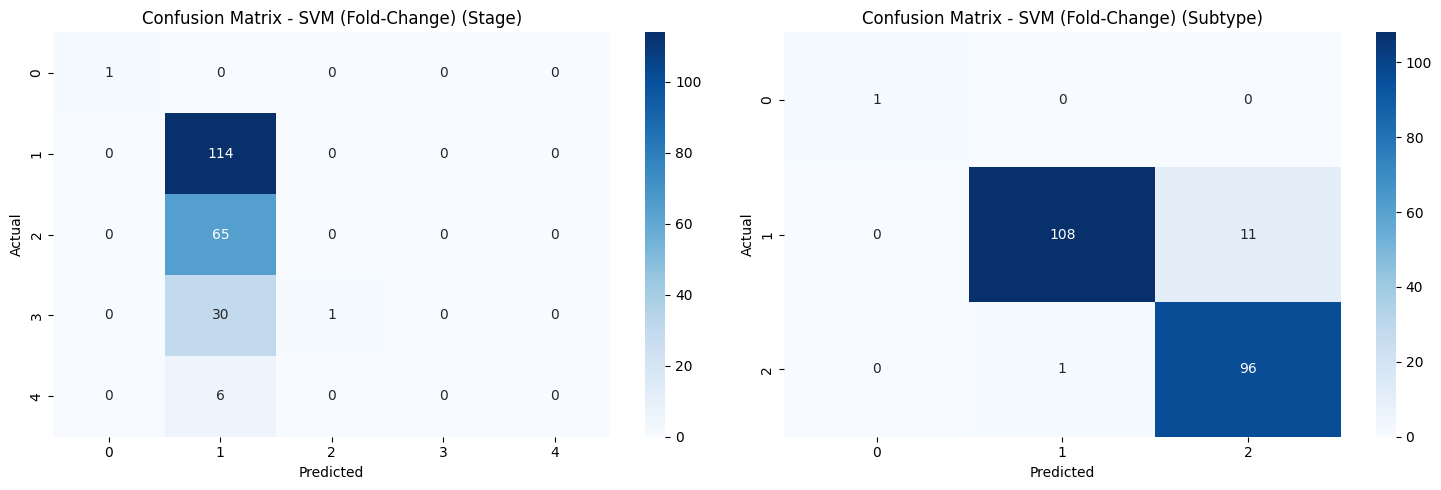

2025-01-31 18:20:29,256 - INFO - 
Model Evaluation Completed! 
2025-01-31 18:20:29,256 - INFO - Stage Accuracy: 0.5300
2025-01-31 18:20:29,257 - INFO - Subtype Accuracy: 0.9447
2025-01-31 18:20:29,257 - INFO - Stage Confusion Matrix: [[1, 0, 0, 0, 0], [0, 114, 0, 0, 0], [0, 65, 0, 0, 0], [0, 30, 1, 0, 0], [0, 6, 0, 0, 0]]
2025-01-31 18:20:29,258 - INFO - Subtype Confusion Matrix: [[1, 0, 0], [0, 108, 11], [0, 1, 96]]


In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

def evaluate_multioutput_model(y_test, y_pred, model_name="SVM (Fold-Change)", save_dir="../results/svm_fold_change/"):
    """
    Evaluate multi-output model performance with confusion matrices, per-class accuracy, and logs.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
    
    # Convert predictions to DataFrame for easy handling
    y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test.index)

    # Evaluate Stage Classification
    stage_accuracy = accuracy_score(y_test["stage"], y_pred_df["stage"])
    stage_cm = confusion_matrix(y_test["stage"], y_pred_df["stage"])
    stage_report = classification_report(y_test["stage"], y_pred_df["stage"])

    # Evaluate Subtype Classification
    subtype_accuracy = accuracy_score(y_test["subtype"], y_pred_df["subtype"])
    subtype_cm = confusion_matrix(y_test["subtype"], y_pred_df["subtype"])
    subtype_report = classification_report(y_test["subtype"], y_pred_df["subtype"])

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    
    print("\nStage Classification:")
    print(f"Accuracy: {stage_accuracy:.4f}")
    print("\nClassification Report:\n", stage_report)
    print("\nConfusion Matrix:\n", stage_cm)
    
    print("\nSubtype Classification:")
    print(f"Accuracy: {subtype_accuracy:.4f}")
    print("\nClassification Report:\n", subtype_report)
    print("\nConfusion Matrix:\n", subtype_cm)

    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix for Stage
    plt.subplot(121)
    sns.heatmap(stage_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_test["stage"].unique()),
                yticklabels=sorted(y_test["stage"].unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Stage)')

    # Confusion Matrix for Subtype
    plt.subplot(122)
    sns.heatmap(subtype_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_test["subtype"].unique()),
                yticklabels=sorted(y_test["subtype"].unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Subtype)')
    
    plt.tight_layout()

    # Save the plots
    stage_cm_path = os.path.join(save_dir, "svm_fold_change_stage_confusion_matrix.png")
    subtype_cm_path = os.path.join(save_dir, "svm_fold_change_subtype_confusion_matrix.png")
    plt.savefig(stage_cm_path)
    plt.savefig(subtype_cm_path)
    print(f"\nConfusion matrices saved to {save_dir}")

    plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed! ")
    logging.info(f"Stage Accuracy: {stage_accuracy:.4f}")
    logging.info(f"Subtype Accuracy: {subtype_accuracy:.4f}")
    logging.info(f"Stage Confusion Matrix: {stage_cm.tolist()}")
    logging.info(f"Subtype Confusion Matrix: {subtype_cm.tolist()}")

    # Return metrics as dictionary
    return {
        "stage_accuracy": stage_accuracy,
        "subtype_accuracy": subtype_accuracy,
        "stage_confusion_matrix": stage_cm.tolist(),
        "subtype_confusion_matrix": subtype_cm.tolist(),
        "stage_classification_report": stage_report,
        "subtype_classification_report": subtype_report
    }

# Run evaluation
save_dir = "../results/svm_fold_change/"
metrics = evaluate_multioutput_model(y_test, y_pred, model_name="SVM (Fold-Change)", save_dir=save_dir)

### Visualize Performance Metrics (Fold-Change Only)

Metrics comparison saved to ../results/svm_fold_change/plots/stage_metrics_comparison.png


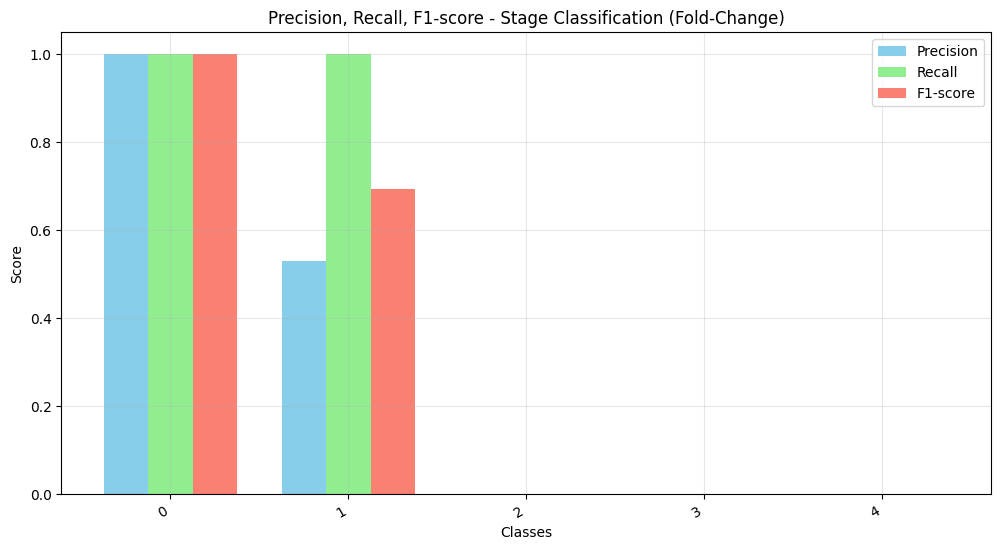

Metrics comparison saved to ../results/svm_fold_change/plots/subtype_metrics_comparison.png


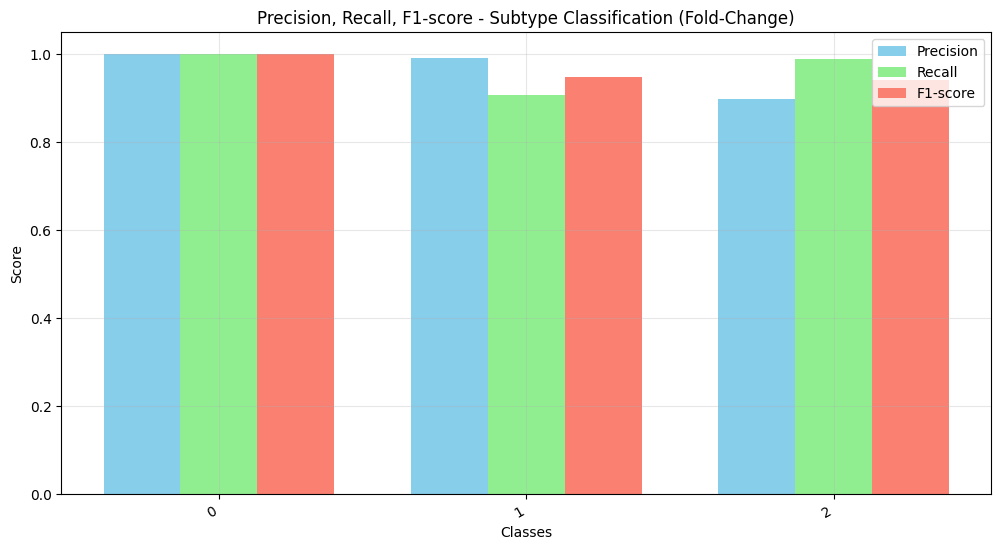

In [30]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define save directory
save_dir = "../results/svm_fold_change/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)
    
    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# Stage Visualization
stage_labels = sorted(y_test["stage"].unique())
plot_metrics_comparison(y_test["stage"], y_pred[:, 0], stage_labels, "Precision, Recall, F1-score - Stage Classification (Fold-Change)", save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

# Subtype Visualization
subtype_labels = sorted(y_test["subtype"].unique())
plot_metrics_comparison(y_test["subtype"], y_pred[:, 1], subtype_labels, "Precision, Recall, F1-score - Subtype Classification (Fold-Change)", save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline (Fold-Change Only, Updated)

In [ ]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm_fold_change/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test.index)

predictions_path = os.path.join(output_dir, "svm_fold_change_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_fold_change_actual_labels.csv")
y_test.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "best_hyperparameters": grid_search.best_params_,
    "stage_accuracy": metrics["stage_accuracy"],
    "subtype_accuracy": metrics["subtype_accuracy"],
    "stage_confusion_matrix": metrics["stage_confusion_matrix"],
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"],
    "train_set_size": X_train.shape[0],
    "test_set_size": X_test.shape[0]
}

metadata_path = os.path.join(output_dir, "svm_fold_change_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Trained Model
model_path = os.path.join(output_dir, "svm_fold_change_model.pkl")
joblib.dump(best_svm, model_path)
logging.info(f"Trained model saved to {model_path}")
print(f"Trained model saved to {model_path}")

print("\nAll results successfully saved. The Fold-Change baseline SVM pipeline is complete.")
